# Coil Generation of Complex-Valued Flows of Probability

This exercise will demonstrate how coils can be extended to describe the flows of complex-valued probability. One of the key aspects of this demonstration will show that in the complex case, the normalization rule is that complex vectors must add up to some point along the complex unit circle, as opposed to summing to 1 as in the real-valued case. 

First we need a reusable way of generating a tensor of complex numbers that sum to be some specified point along the complex unit circle. To help, let's use a simple function to plot out complex tensors tip-to-tail to ensure they meet this criteria.

In [571]:
import matplotlib.pyplot as plt
import numpy as np

def plot_complex_vectors(complex_array):
    # Plot the unit circle
    angles = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(angles), np.sin(angles), linestyle='dotted')

    # Starting point for the vectors
    start = 0 + 0j
    for z in complex_array:
        # Plot each vector
        end = start + z
        plt.arrow(start.real, start.imag, z.real, z.imag,
                  head_width=0.05, head_length=0.05, length_includes_head=True)
        start = end

    # Set equal scaling and labels
    plt.axis('equal')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.grid(True)
    plt.title('Complex Vectors Summation')

    # Show the plot
    plt.show()

## Complex Coil Normalization

As we want our complex-valued vectors to add up to some point along the complex unit circle, we will deploy a few techniques to help us generate complex vectors that fulfill these requirements. We will show how we can do this with a combination of Radial Basis Function kernels and Dirichlet distribution sampling. 

### Radial Basis Functions Kernels

First we need customiseable Radial Basis Function kernels to prioritize the weightings in our Dirichlet distribution sampling. 

In [572]:
import torch

def generate_rbf(length, center_index, sigma):
    """
    Generates a 1D radial basis function (Gaussian) of specified width centered on a given index.

    Parameters:
    length (int): The length of the output tensor.
    center_index (int): The index at which the RBF is centered.
    sigma (float): The standard deviation (width) of the RBF.

    Returns:
    torch.Tensor: A 1D tensor representing the radial basis function.
    """
    if center_index >= length or center_index < 0:
        raise ValueError("Center index must be within the range of the tensor length.")

    # Create an array of indices
    x = torch.arange(0, length, dtype=torch.float32)

    # Calculate the RBF
    rbf = torch.exp(-0.5 * ((x - center_index) / sigma) ** 2)

    return rbf

def generate_kernel(length, center_index, type = "rbf", restrictions = [], **kwargs):
    if type == "rbf":
        kernel = generate_rbf(length, center_index, kwargs['sigma'])
        
    # Replace zero values with min_value
    kernel = torch.where(kernel == 0, torch.tensor(1e-30, dtype=kernel.dtype), kernel)
    
    # Set restrictions to 0
    kernel[restrictions] = 1e-30
    
    return kernel


The parameters of this radial basis function control the location of the peak and the spread of the distribution. We can make a narrow distribution centered on index 5:

tensor([3.7267e-06, 3.3546e-04, 1.1109e-02, 1.3534e-01, 6.0653e-01, 1.0000e+00,
        6.0653e-01, 1.3534e-01, 1.1109e-02, 3.3546e-04])


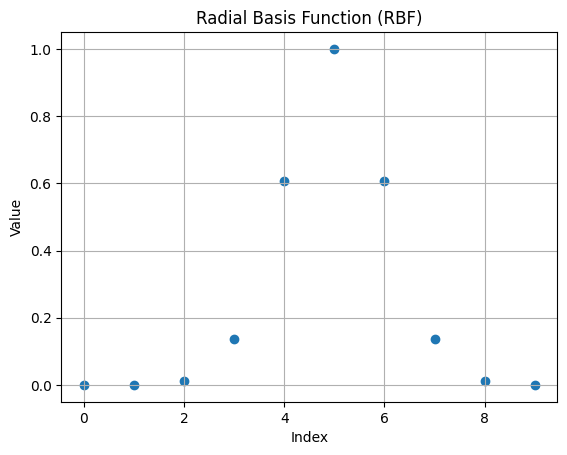

In [573]:
# Example usage
length = 10  # Length of the tensor
center_index = 5  # Center the RBF at index 5
sigma = 1  # Standard deviation of the RBF

rbf_tensor = generate_kernel(length, center_index, type = "rbf", sigma=sigma)
print(rbf_tensor)

# Plotting the RBF
plt.scatter(torch.arange(length), rbf_tensor)
plt.title("Radial Basis Function (RBF)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()

Or make a wide distribution centered at index 3:

tensor([0.9560, 0.9802, 0.9950, 1.0000, 0.9950, 0.9802, 0.9560, 0.9231, 0.8825,
        0.8353])


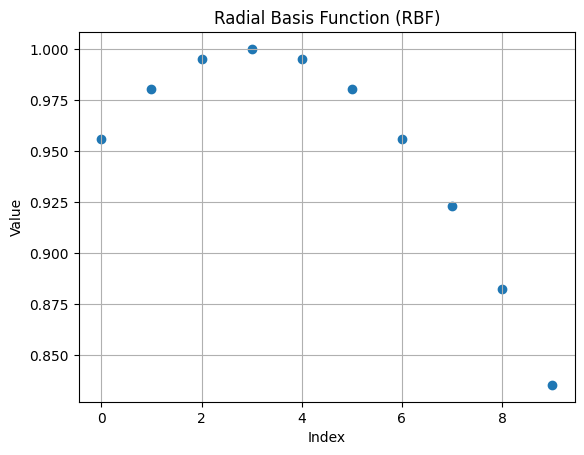

In [574]:
# Example usage
length = 10  # Length of the tensor
center_index = 3  # Center the RBF at index 3
sigma = 10  # Standard deviation of the RBF

rbf_tensor = generate_kernel(length, center_index, type = "rbf", sigma=sigma)
print(rbf_tensor)

# Plotting the RBF
plt.scatter(torch.arange(length), rbf_tensor)
plt.title("Radial Basis Function (RBF)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()

We can also force certain indices to be nearly 0 using the ```restrictions``` argument:

tensor([9.5600e-01, 9.8020e-01, 9.9501e-01, 1.0000e+00, 1.0000e-30, 9.8020e-01,
        9.5600e-01, 9.2312e-01, 8.8250e-01, 8.3527e-01])


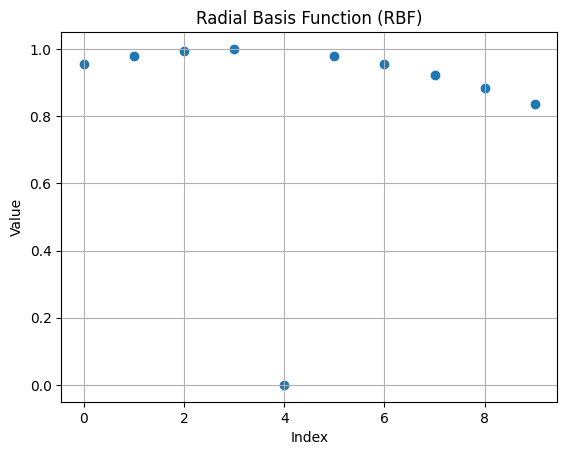

In [575]:
# Example usage
length = 10  # Length of the tensor
center_index = 3  # Center the RBF at index 3
sigma = 10  # Standard deviation of the RBF

rbf_tensor = generate_kernel(length, center_index, type = "rbf", sigma=sigma, restrictions=[4])
print(rbf_tensor)

# Plotting the RBF
plt.scatter(torch.arange(length), rbf_tensor)
plt.title("Radial Basis Function (RBF)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()

#### Generating Normalized Complex-Valued Vectors

We can generate a complex array that sums to a point along the complex unit circle by sampling from Dirichlet distributions for the real and complex parts, with the weighting of the sampling given by RBF kernels. As the sum of samples from a Dirichlet distribution sum to 1, it is easiest to actually start with the vectors adding up to $1 + 0i$ and then rotating the array to the desired point along the unit circle. 

However, this would require the Dirichlet samples for the imaginary portion summing up to 0. This can be done simply by subtracting the mean of the entire array of imaginary parts from each element of the array, or can be generalized with the following function. 

In [576]:
def rescale_array_to_target_torch(tensor, target_sum):
    # Create a mask for non-zero elements
    non_zero_mask = tensor > 1e-10

    # Calculate the sum of non-zero elements
    sum_non_zero = torch.sum(tensor[non_zero_mask])

    # Count the non-zero elements
    count_non_zero = torch.sum(non_zero_mask)
    
    # Avoid division by zero in case all elements are zero
    if count_non_zero == 0:
        return torch.zeros_like(tensor)

    # Calculate the required adjustment to reach the target sum
    adjustment = (target_sum - sum_non_zero) / count_non_zero
    
    # Add the adjustment to each non-zero element
    tensor[non_zero_mask] += adjustment

    return tensor

The RBF is used for weighting the dirichlet distribution sampling for the real and imaginary parts, with the ```generate_complex_sum``` function handling the rotation of the vectors. 

In [577]:
def dirichlet_to_goal(goal_value, num_elements, center_index, sigma, magnitude, restrictions):
    # Generate alphas for dirichlet
    alphas = generate_kernel(length = num_elements, center_index = center_index, type = "rbf", sigma = sigma, restrictions = restrictions) * magnitude
    rand_samples = torch.distributions.Dirichlet(alphas).sample()
    
    rand_samples = rescale_array_to_target_torch(rand_samples, goal_value)
    
    return rand_samples

def generate_complex_sum(goal_theta, num_elements, center_index_re, center_index_im, sigma_re, sigma_im, magnitude_re, magnitude_im, restrictions = []):
    real_goal = torch.cos(goal_theta)
    imag_goal = torch.sin(goal_theta)
    real_parts = dirichlet_to_goal(1.0, num_elements, center_index_re, sigma_re, magnitude_re, restrictions)
    imag_parts = dirichlet_to_goal(0.0, num_elements, center_index_im, sigma_im, magnitude_im, restrictions)
    complex_numbers = torch.complex(real_parts, imag_parts)
    
    # Step 4: Rotate the entire set of vectors by the goal theta
    rotated_complex_numbers = complex_numbers * (real_goal + imag_goal * 1j)
    
    rotated_complex_numbers = torch.tensor(rotated_complex_numbers, dtype=torch.complex128)

    return rotated_complex_numbers

By selecting some point along the complex unit circle, we can generate a complex array that sums to that point.

C:\Users\johnm\AppData\Local\Temp\ipykernel_19204\212979098.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotated_complex_numbers = torch.tensor(rotated_complex_numbers, dtype=torch.complex128)


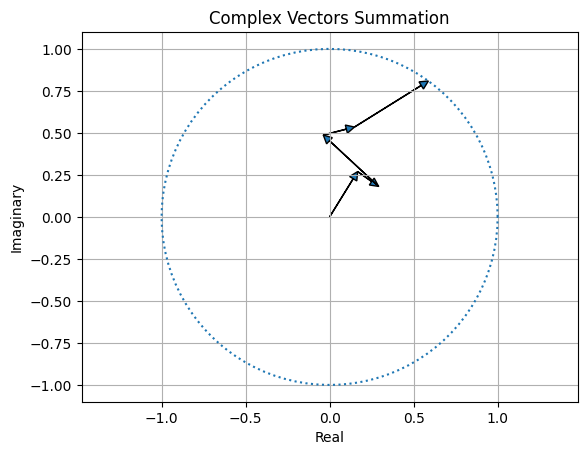

In [578]:
# Example usage
theta = torch.tensor([0.3 * torch.pi], dtype=torch.float64) 
complex_array = generate_complex_sum(theta, 
                                     num_elements = 5, 
                                     center_index_re = 3, 
                                     center_index_im = 3, 
                                     sigma_re = 1e100, 
                                     sigma_im = 1e100, 
                                     magnitude_re = 1, 
                                     magnitude_im = 1,
                                     restrictions = [])
plot_complex_vectors(complex_array.numpy())

Recall that the ```sigma``` arguments handle the distribution of the radial basis function for the real and imaginary parts. When ```sigma``` is very large, the RBF resembles a uniform distribution. When ```sigma``` is smaller, the dirichlet sample will be weighted closer to the RBF center index. 

We can use this behaviour to ensure that certain complex values in the array are larger than others:

C:\Users\johnm\AppData\Local\Temp\ipykernel_19204\212979098.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotated_complex_numbers = torch.tensor(rotated_complex_numbers, dtype=torch.complex128)


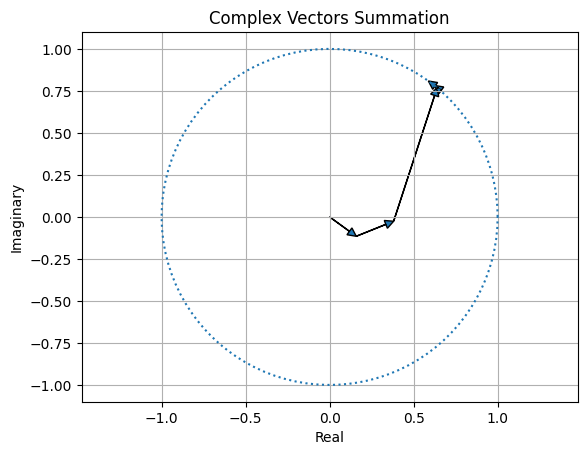

In [579]:
# Example usage
theta = torch.tensor([0.3 * torch.pi], dtype=torch.float64) 
complex_array = generate_complex_sum(theta, 
                                     num_elements = 5, 
                                     center_index_re = 2, 
                                     center_index_im = 2, 
                                     sigma_re = 0.5, 
                                     sigma_im = 1e100, 
                                     magnitude_re = 1, 
                                     magnitude_im = 1,
                                     restrictions = [])
plot_complex_vectors(complex_array.numpy())

In this example, the RBF is centered on index 2 with a narrow distribution, so when we sample from a Dirichlet distribution for the real part of the array, that element will be substantially larger than the others. 

## Initial State Generation

```generate_complex_sum``` is sufficient for generating our initial state tensor, so let's make some helper functions to generate our initial transition tensor and interaction tensor. 

### Initial Transition Tensor
In generating a transition tensor, we can use the RBF kernels to make it more likely to stay in the current state, effectively slowing the dynamics of the system. 

Additionally, we can use different ```sigma_re``` values for more interesting behaviours, allowing parts of the system to transition more quickly on average than others. 

Note that this function takes a single ```theta``` value indicating the desired rotation of each column sum in the transition tensor. This is because normalization only holds if each normalized group of the transition tensor sums to same point along the complex unit circle. Similarly, each normalized group of the interaction tensor must sum to the same point along the complex unit circle, though this point doesn't need to be the same as that of the transition tensor. 

In [580]:
# Transition tensor:
def initialize_transition_tensor(num_elements, theta, restrict_dict = []):
    # Create a list to store each column
    columns = []
    num_columns = num_elements

    for col in range(num_columns):
        
        if col in restrict_dict:
            restrictions = restrict_dict[col]
        else:
            restrictions = []
        
        # Center the values on the index that will make it more likely to stay in current state. 
        column = generate_complex_sum(theta, 
                    num_elements = num_elements, 
                    center_index_re = col, 
                    center_index_im = 0, 
                    sigma_re = torch.rand(1)[0]*0.3 + 0.2, 
                    sigma_im = 1e10, 
                    magnitude_re = 1.0, 
                    magnitude_im = 1e5,
                    restrictions = restrictions)
        columns.append(column.unsqueeze(1))  # Add a dimension to make it a column

    # Combine columns into a matrix
    transition_tensor = torch.cat(columns, dim=1)
    
    return transition_tensor

### Initial Interaction Tensor

A similar approach can be used to generate our interaction tensor. 

In [581]:
# Interaction Tensor Create:
def initialize_interaction_tensor(num_elements, theta, restrict_dict = []):
    # Example usage
    num_3d_tensors = num_elements + 1  # Number of 3D tensors in the 4D tensor
    num_matrices = num_elements  # Number of 2D matrices in each 3D tensor
    num_columns = num_elements  # Number of columns in each 2D matrix

    # Create a list to store each 3D tensor
    tensors_3d = []

    for _ in range(num_3d_tensors):
        matrices = []
        for _ in range(num_matrices):
            columns = []
            for col in range(num_columns):
                
                if col in restrict_dict:
                    restrictions = restrict_dict[col]
                else:
                    restrictions = []
                    
                column = generate_complex_sum(theta, 
                                    num_elements = num_elements, 
                                    center_index_re = col, 
                                    center_index_im = 0, 
                                    sigma_re = torch.rand(1)[0]*0.3 + 0.2, 
                                    sigma_im = 1e10, 
                                    magnitude_re = 1.0, 
                                    magnitude_im = 1e5,
                                    restrictions = restrictions)
                columns.append(column.unsqueeze(1))  # Add a dimension to make it a column
            matrix = torch.cat(columns, dim=1)
            matrices.append(matrix)  # Add a dimension to make it a 2D matrix
        tensor_3d = torch.stack(matrices, dim=2)
        tensors_3d.append(tensor_3d)

    # Combine 3D tensors into a 4D tensor
    # Stack along the fourth dimension
    interaction_tensor = torch.stack(tensors_3d, dim=3)
    
    return interaction_tensor

Note that both of these initialization functions take ```restrict_dict``` as an argument. This can be used to prevent transitions between certain states. For example, if we consider an example with 5 states and treat them as segments in a one-dimensional space, we can enforce locality by restricting any segments not immediately adjacent from transititioning with one another. 

In [582]:
# Local restriction example for a 5-state, 1D system
restrict_dict = {
    0: [2, 3, 4],
    1: [3, 4],
    2: [0, 4],
    3: [0, 1],
    4: [0, 1, 2]
}

Alternatively, we can use restrictions to make groups that are unable to tranfer between one another but still interact. For example in a 5-state system, what if states 0 and 1 are in a group and 2, 3, and 4 are in another, where the system cannot move from state 0 to 2, etc?

In [583]:
# Grouping example for a 5-state
restrict_dict = {
    0: [2, 3, 4],
    1: [2, 3, 4],
    2: [0, 1],
    3: [0, 1],
    4: [0, 1]
}

We can use the above functions to customize the generation of our complex coils.

In [584]:
num_elements = 5

# Thetas for state, transition, and interactions
angles_dict = {
    'state': 0.3,
    'transition': 0.2,
    'interaction': 0.4
}

# No restrictions
restrict_dict = {}

thetas_dict = {key : torch.tensor([value * torch.pi]) for key, value in angles_dict.items()}

# Establish state_tensor
state_tensor = generate_complex_sum(thetas_dict['state'], 
                                     num_elements = num_elements, 
                                     center_index_re = 0, 
                                     center_index_im = 0, 
                                     sigma_re = 1e100, 
                                     sigma_im = 1e100, 
                                     magnitude_re = 1, 
                                     magnitude_im = 100,
                                     restrictions = [])
transition_tensor = initialize_transition_tensor(theta = thetas_dict['transition'], num_elements = num_elements, restrict_dict=restrict_dict)
interaction_tensor = initialize_interaction_tensor(theta = thetas_dict['interaction'], num_elements = num_elements, restrict_dict=restrict_dict)

# Move everything to GPU
state_tensor = state_tensor.to('cuda:0')
transition_tensor = transition_tensor.to('cuda:0')
interaction_tensor = interaction_tensor.to('cuda:0')

C:\Users\johnm\AppData\Local\Temp\ipykernel_19204\212979098.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotated_complex_numbers = torch.tensor(rotated_complex_numbers, dtype=torch.complex128)


## Normalization Testing
Let's first do some quick tests to make sure our complex normalization is working as intended. First we can simply generate a new state tensor using our transition tensor and old state tensor:

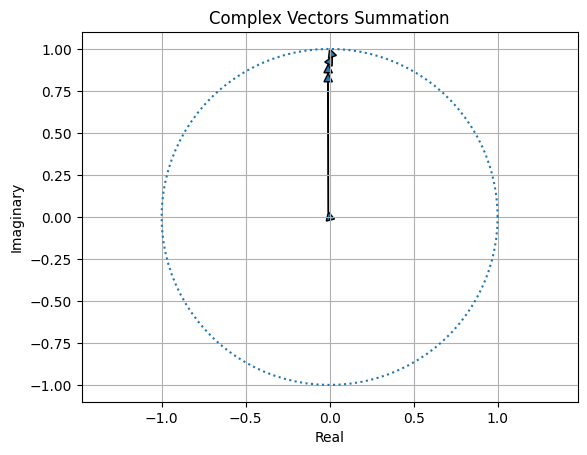

In [585]:
# First just checking that our initial transition tensor looks good:
new_state_tensor = torch.matmul(transition_tensor,state_tensor)

plot_complex_vectors(new_state_tensor.to('cpu').numpy())

As we can see, this new state tensor sums up to a point along the unit circle. We can confirm this by checking if the sum of the array multipied by the complex conjugate of its sum is 1:

In [586]:
sum(new_state_tensor * torch.conj(sum(new_state_tensor)))

tensor(1.0000+0.j, device='cuda:0', dtype=torch.complex128)

Similarly, we can check that the use of the interaction tensor maintains normalization by selecting a distinct normalized group for the transition calculation:

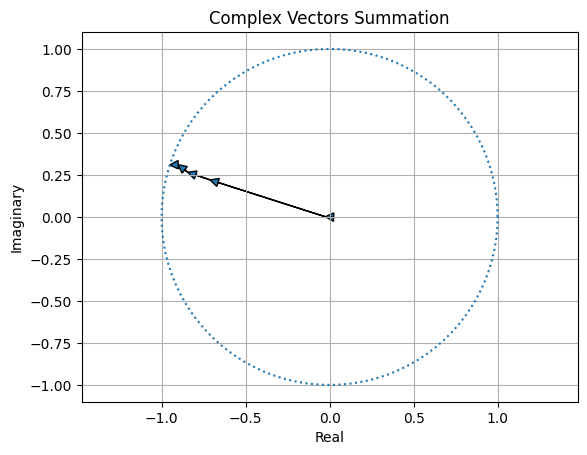

In [587]:
# Now we check that our interaction tensor works as intended
selection = 1

if selection == 0:
    selected_normalized_tensor = state_tensor
else:
    selected_normalized_tensor = transition_tensor[:,selection-1]
    
selected_interaction_tensor = interaction_tensor[:,:,:,selection]

new_transition_tensor = torch.matmul(selected_interaction_tensor, selected_normalized_tensor)

new_state_tensor = torch.matmul(new_transition_tensor, state_tensor)

plot_complex_vectors(new_state_tensor.to('cpu').numpy())

In [588]:
sum(new_state_tensor * torch.conj(sum(new_state_tensor)))

tensor(1.0000-7.9797e-17j, device='cuda:0', dtype=torch.complex128)

## Extension of Batch Dimension

While we are not using batches in this implementation of complex coil generation, we find for consistency with other applications we can add a batch dimension to our state and transition tensors. This is not needed for our interaction tensor as it does not change. 

In [589]:
state_tensor = state_tensor.unsqueeze(0)
transition_tensor = transition_tensor.unsqueeze(0)

## Weighted Selection

As mentioned in the coil derivation, we can use weighted selections instead of discrete selection, which begs the question of how we might be able to find our weighting matrix for selection. In this application, we will say we want our selection to prioritize the candidate transition tensor that maximizes the probability of transiitoning from what is currently the state with the highest probability to the state with the lowest probability. This can be done discretely, however the continuous implementation is more applicable. 

First, as before, we combine the state and transition tensors into a norm_subgroups tensor:

In [590]:
norm_subgroups = torch.cat((state_tensor.unsqueeze(-1), transition_tensor), dim=2)

-----
#### Equivalence Check

We can confirm that we set up the norm_subgroups correctly by looking at some slices

In [591]:
print(torch.isclose(norm_subgroups[0,:,5] , transition_tensor[0,:,4]))
print(torch.isclose(norm_subgroups[0,:,0] , state_tensor[0,:]))
print(torch.isclose(norm_subgroups[0,:,2] , transition_tensor[0,:,1]))

tensor([True, True, True, True, True], device='cuda:0')
tensor([True, True, True, True, True], device='cuda:0')
tensor([True, True, True, True, True], device='cuda:0')


-----

We can get our candidate transition tensors like this:

In [592]:
candidate_transition_tensors = (torch.mul(interaction_tensor, norm_subgroups.unsqueeze(1).unsqueeze(1))).sum(-2) # [batches, states, states, states + 1]
print(candidate_transition_tensors.shape)

torch.Size([1, 5, 5, 6])


-----
#### Equivalence Check

This is a more compact form of the looped approach we used in the coil derivation so we can confirm this calculation is correct by checking the candidate tensor for a single slice:

In [593]:
slice_sel = 3
batch_sel = 0
slice_transition_check = torch.matmul(interaction_tensor[:,:,:,slice_sel],norm_subgroups[batch_sel ,:,slice_sel])

torch.isclose(candidate_transition_tensors[batch_sel,:,:,slice_sel], slice_transition_check)

tensor([[True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True]], device='cuda:0')

We can also confirm that both methods are still normalized:

In [594]:
print(sum(slice_transition_check[:,1] * torch.conj(torch.sum(slice_transition_check[:,1]))))
print(sum(candidate_transition_tensors[batch_sel,:,3,slice_sel] * torch.conj(torch.sum(candidate_transition_tensors[batch_sel,:,3,slice_sel]))))

tensor(1.0000+2.0817e-17j, device='cuda:0', dtype=torch.complex128)
tensor(1.0000+3.9031e-18j, device='cuda:0', dtype=torch.complex128)


------

For this application, to handle the complex values we will measure states by looking at the sum of the absolute values of the real and imaginary parts:

In [595]:
def complex_add(tensor):
    return torch.abs(torch.real(tensor)+torch.imag(tensor))

We can "focus" on the transition value that represents the transitioning from the highest probability state to the lowest probability state across candidate transition tensors by utilizing softmax activations applied to the states:

In [596]:
sel_temperature = 0.001

high_magnitude = torch.softmax((complex_add(state_tensor) / sel_temperature), dim = 1)
low_magnitude = torch.softmax(1 - (complex_add(state_tensor) / sel_temperature), dim = 1)
largest_state = torch.where(high_magnitude == high_magnitude.max())[1][0]
smallest_state = torch.where(low_magnitude == low_magnitude.max())[1][0]
print("State Tensor: ", state_tensor)
print("Highest Probability State: ",largest_state)
print("Lowest Probability State: ", smallest_state)

State Tensor:  tensor([[0.0094+0.0251j, 0.4200+0.5835j, 0.0975+0.1307j, 0.0473+0.0223j,
         0.0136+0.0474j]], device='cuda:0', dtype=torch.complex128)
Highest Probability State:  tensor(1, device='cuda:0')
Lowest Probability State:  tensor(0, device='cuda:0')


We can see that this method correctly identifies the highest and lowest probability state. We can use this to determine which of the candidate transition tensors maximizes our transition of interest by multiplying the candidate transition tensors by these focusing values. 

To demonstrate how this focusing works, let's look at a heatmap of one "focused" candidate transition tensor. 

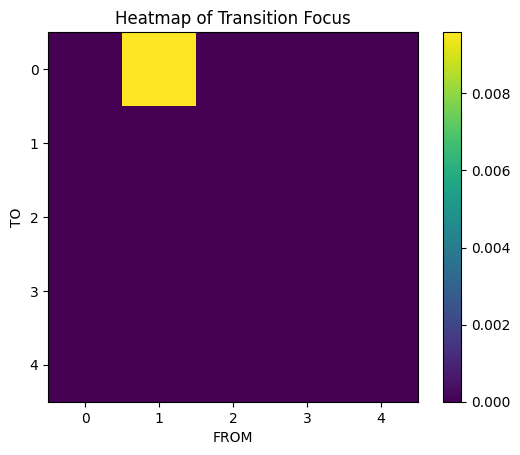

In [597]:
tensor_2d = complex_add(torch.mul(torch.mul(candidate_transition_tensors, high_magnitude.unsqueeze(2).unsqueeze(1)), low_magnitude.unsqueeze(2).unsqueeze(2))[0,:,:,3])
# Convert the tensor to a numpy array
tensor_2d_np = tensor_2d.to("cpu").numpy()

# Create a heatmap using matplotlib
plt.imshow(tensor_2d_np, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Show color scale
plt.title('Heatmap of Transition Focus')
plt.xlabel('FROM')
plt.ylabel('TO')
plt.show()

As this is correctly focusing on the transition from the highest probability state to the lowest probability state, we can sum each of these focused candidate transition tensors, and apply softmax activation across the sums one more time to get a selection weighting:

In [598]:
selection_weights = torch.softmax(complex_add(torch.mul(torch.mul(candidate_transition_tensors, high_magnitude.unsqueeze(2).unsqueeze(1)), low_magnitude.unsqueeze(2).unsqueeze(2))).sum(2).sum(1) / sel_temperature, dim = 1)
print(selection_weights)

tensor([[1.8274e-04, 8.7940e-05, 7.1918e-05, 9.9951e-01, 7.5889e-05, 7.2052e-05]],
       device='cuda:0', dtype=torch.float64)


We can check our approach by seeing where the selection weights is the max

In [599]:
print(torch.where(selection_weights == selection_weights.max())[1][0])

tensor(3, device='cuda:0')


And compare this to directly looking at the candidate transition tensors at this focus location to see which is candidate has the maximum of this transition. Note that dim = 1 (rows) corresponds to the "To" state, while dim = 2 (columns) corresponds to the "From" state. 

In [600]:
slice_sel = complex_add(candidate_transition_tensors[:,smallest_state, largest_state, :])
print(torch.where(slice_sel == slice_sel.max())[1][0])

tensor(3, device='cuda:0')


## Performing Complex Weighting

Now that we have our selection weights, we now need to apply these across our complex-valued candidate transition tensors to get a normalized selected transition tensor. 

This can be accomplished by rotating all of the candidate transition tensors to $1+0i$, doing a traditional weighted sum, and rotating the result back to the original point along the complex unit circle.

------
#### Equivalence Check

First we can confirm that we can rotate to $1+0i$ by multiplying by the complex conjugate of the sum of the tensors, and then rotate back to the original point by dividing by the same complex conjugate of the sum of the original tensors.

In [601]:
# We can do a rotate there-and-back to 1+0i like this
torch.isclose(candidate_transition_tensors,(candidate_transition_tensors * torch.conj(torch.sum(candidate_transition_tensors, dim = 1))) / torch.conj(torch.sum(candidate_transition_tensors, dim = 1)))

tensor([[[[True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True]],

         [[True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True]],

         [[True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True]],

         [[True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True],
          [True, True, True, True, True, True]],

         [[True, True, True, Tru

-----

So we can rotate our candidate transition tensors to $1+0i$ like this:

In [602]:
rotated_candidate_transition_tensors = (candidate_transition_tensors * torch.conj(torch.sum(candidate_transition_tensors, dim = 1)))

And then apply the weighting and rotate them back like this:

In [603]:
selected_transition_tensor = torch.mul(rotated_candidate_transition_tensors, selection_weights.unsqueeze(1).unsqueeze(1)).sum(-1) / torch.conj(torch.sum(candidate_transition_tensors[:,:,:,0], dim = 1))

Note that we just need to rotate back with one of the complex conjugate sums of the original candidate transition tensors - it doesn't matter which we use as they all sum to the same point along the complex unit circle. 

We can check that our selected tensor is still normalized:

In [604]:
# Check normalization
torch.sum(selected_transition_tensor * torch.conj(torch.sum(selected_transition_tensor, dim = 1)), dim =1)

tensor([[1.0000+2.2226e-17j, 1.0000+6.4022e-17j, 1.0000+5.3505e-17j,
         1.0000-2.2985e-17j, 1.0000+4.6783e-17j]], device='cuda:0',
       dtype=torch.complex128)

This selection process can be organized into a single function:

In [605]:
def select_transition_tensor(state_tensor,transition_tensor,interaction_tensor, sel_temperature):
    # Combine state and transition tensors into a norm_subgroups tensor
    norm_subgroups = torch.cat((state_tensor.unsqueeze(-1), transition_tensor), dim=2)
    
    # Get candidate transition tensors:
    candidate_transition_tensors = (torch.mul(interaction_tensor, norm_subgroups.unsqueeze(1).unsqueeze(1))).sum(-2) # [batches, states, states, states + 1]
    
    # Determine the largest and smallest states
    high_magnitude = torch.softmax((complex_add(state_tensor) / sel_temperature), dim = 1)
    low_magnitude = torch.softmax(1 - (complex_add(state_tensor) / sel_temperature), dim = 1)
    
    # Find which transition corresponds to moving from the highest state to the lowest state, and focus on that:
    transition_focus_slices = complex_add(torch.mul(torch.mul(candidate_transition_tensors, high_magnitude.unsqueeze(2).unsqueeze(1)), low_magnitude.unsqueeze(2).unsqueeze(2)))
    
    # Determine the selection weights by which slice is the highest in the focus transition
    selection_weights = torch.softmax(transition_focus_slices.sum(2).sum(1) / sel_temperature, dim = 1)
    
    # Rotate the candidate transition tensors to 1+0i so that we can do a weighted average
    rotated_candidate_transition_tensors = (candidate_transition_tensors * torch.conj(torch.sum(candidate_transition_tensors, dim = 1)))
    
    # Perform weighted averaging and rotate back to the original position (NOTE: we just use the first rotation here because they should all be the same in our case)
    selected_transition_tensor = torch.mul(rotated_candidate_transition_tensors, selection_weights.unsqueeze(1).unsqueeze(1)).sum(-1) / torch.conj(torch.sum(candidate_transition_tensors[:,:,:,0], dim = 1))
    
    return selected_transition_tensor

## Coil Dynamics

Now that we can generate our initial tensors and perform selection, we are ready to generate flows of complex-valued probability. 

### Renormalization

In theory, the previous steps should ensure conservation. However, even when using a precision of complex128, there are still memory errors that cause us to lose conservation. Therefore we can optionally renormalize. 

In [606]:
def renormalize_to_unit_circle(array, dim = 1):
    """
    Renormalizes an array of complex numbers so that it sums to a point on the unit circle.

    Parameters:
    array (torch.Tensor): A 1D tensor of complex numbers.

    Returns:
    torch.Tensor: A renormalized 1D tensor of complex numbers.
    """
    current_sum = torch.sum(array, dim = dim)
    # Calculate the magnitude of the current sum
    magnitude = torch.abs(current_sum)

    # Calculate the scale factor
    scale_factor = 1 / magnitude

    # Renormalize the array
    renormalized_array = array * scale_factor

    return renormalized_array

### Complex Coil Simulation

Now we can simply generate new transition tensors and then new state tensors indefinitely. We will just save the state probability, which is just the real part of the state tensor rotated to $1+0i$. 

In [607]:
import time

tic = time.time()

num_steps = 10_000
prob_save = []

for i_step in range(num_steps):
    transition_tensor = select_transition_tensor(state_tensor,transition_tensor,interaction_tensor, sel_temperature = 1e-5)

    state_tensor = torch.mul(transition_tensor, state_tensor.unsqueeze(1)).sum(dim = -1)

    # Optionally we can renomalize to avoid floating point precision errors
    state_tensor = renormalize_to_unit_circle(state_tensor)
    transition_tensor = renormalize_to_unit_circle(transition_tensor)

    state_prob = torch.real(state_tensor[0,:] * torch.conj(state_tensor[0,:].sum()))

    prob_save.append(state_prob)
    
    
toc = time.time()    
print(f"Processing time: {round(toc-tic,4)}s")
print(state_prob.sum())

Processing time: 13.9362s
tensor(1., device='cuda:0', dtype=torch.float64)


We can plot the temporal dynamics of the real-valued probability, calculated from the complex-valued probability dynamics of a coil.

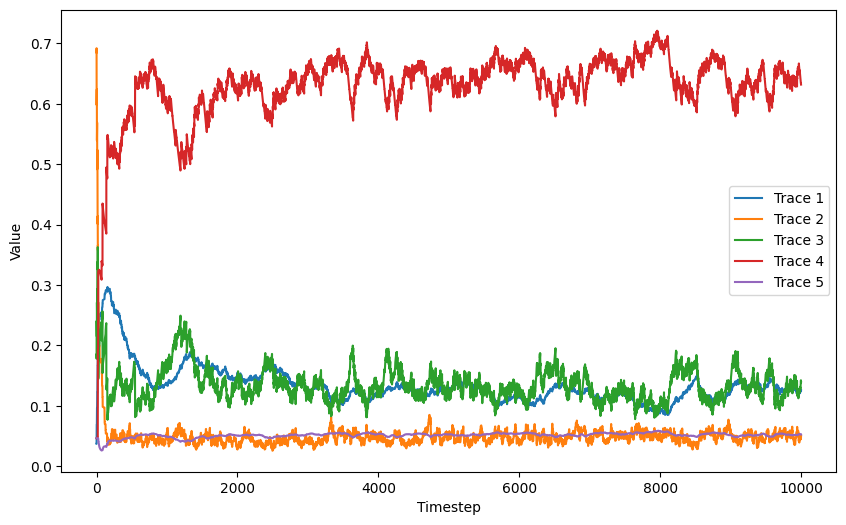

In [608]:
data = [row.to('cpu') for row in prob_save]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

Of course, upon viewing the long-term dynamics and aperiodic oscillation of the coil, it is worth empahsizing that the dynamics of the coil is completely deterministic. 